# Calculating realized volatility over uniswap pools

The general intention here os to find an approach that can be used to calculate realized volatility
inside a ZkVM minimizing proof generation time.



First, parse the data in the `output` folder. Inside `/files`, there are the events
of 10,000 blocks. The files first need to be parsed for the `amount0` and `amount1` values.

All the `amount0` and `amount1` are pairs, where when one is positive the other is negative. The positive value will
be token being sent to the pool and the negative value is the token being extracted from the pool. Which means that
the positive was used to buy the negative. For example:

```
{"evt_tx_hash":"269b472f4e3f12475c8c87a2446377ab277bbdb083cd1b90184ca140869d3d14","evt_index":125,"evt_block_time":"2022-02-23T03:37:33Z","evt_block_number":14259969,"sender":[104,179,70,88,51,251,114,167,14,205,244,133,224,228,199,189,134,101,252,69],"recipient":[104,179,70,88,51,251,114,167,14,205,244,133,224,228,199,189,134,101,252,69],"amount0":"600000000","amount1":"-228943146269552415","sqrt_price_x96":"1548018970258445765029698839921509","liquidity":"24397164349123642323","tick":197612}
```

The transaction above means that the `amount0` (which is USDC) bought the `amount1` (ETH). Since this is ETH/USDC pool it is safe to assume whenever
the `amount` is positive it means a buy of ETH with USDC and whenever it is negative it means a sell. 


The general calculation for realized volatility over the uniswap data goes as follows:

First, pick the closing prices for the days, to calculate the volatility based on them:

In [3]:
# system packages 
import os
import json

# external packages 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# internal packages


In [4]:
def parse_json_file(file_path):
    lines = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                json_obj = json.loads(line)
                lines.append(json_obj)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {file}: {e}")
    return lines



def parse_jsonl_files_in_folder(folder_path):
    lines = []
    
    files = os.listdir(folder_path)
    
    jsonl_files = sorted([f for f in files if f.endswith('.jsonl')])
    
    for jsonl_file in jsonl_files:
        file_path = os.path.join(folder_path, jsonl_file)
        lines += parse_json_file(file_path)
    return lines


In [49]:
folder_path = '../../output/files'
parse_jsonl_files_in_folder(folder_path)
%%capture

UsageError: Line magic function `%%capture` not found.


The price is also calculated and set into the data frame below:

In [6]:
json_data = parse_json_file('../../output/files/0014250000-0014260000.jsonl')

df = pd.DataFrame(json_data)

# Convert USDC and ETH to floats
df['USDC_float'] = abs(df['amount0'].astype(float) / 10**6)
df['ETH_float'] = abs(df['amount1'].astype(float) / 10**18)
df['price'] = df['USDC_float'] / df['ETH_float']

df.head(3)

,evt_tx_hash,evt_index,evt_block_time,evt_block_number,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,tick,USDC_float,ETH_float,price
0,fcc3ee07bf8d919ab9de764f18bc5ef418856a39f185c2...,2,2022-02-21T14:37:39Z,14250006,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",10478339758,-3884917900821301808,1525917532358317971760838574935194,24251487342182036943,197325,10478.339758,3.884918,2697.184349
1,bc79ade25faa4a0265525b01f78d7a2fc3f7b3a57b50ea...,437,2022-02-21T14:37:54Z,14250010,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[211, 78, 72, 85, 20, 106, 192, 198, 208, 228,...",4340404907,-1609216608786697661,1525912275143648921512703657856255,24251487342182036943,197325,4340.404907,1.609217,2697.216076
2,c52492625f987f9e9e9307c7563888f74497f7bbb3d64e...,634,2022-02-21T14:38:33Z,14250012,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",750000000,-278063361874639352,1525911366727232516908683992960707,24251487342182036943,197325,750.000000,0.278063,2697.226974


In [7]:
df['evt_block_time'].min(), df['evt_block_time'].max()

('2022-02-21T14:37:39Z', '2022-02-23T03:41:30Z')

It is possible to filter the "closing prices" of each day in the following manner. Although this might not be a good metric for
DeFi protocols, the closing prices are common when calculating realized volatility in markets.

In [8]:
# Convert evt_block_time to datetime format
df['evt_block_time'] = pd.to_datetime(df['evt_block_time'])

# Extract date part for grouping
df['date'] = df['evt_block_time'].dt.date

# Group by the date and get the last entry for each group
last_of_day = df.sort_values('evt_block_time').groupby('date').tail(1)

# Drop the extra 'date' column if not needed
last_of_day = last_of_day.drop(columns=['date'])

#Display the result


In [9]:
last_of_day

,evt_tx_hash,evt_index,evt_block_time,evt_block_number,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,tick,USDC_float,ETH_float,price
2673,927e6cd3cdc5b27608e4128cc849b91836680f1df9acbe...,131,2022-02-21 23:59:35+00:00,14252517,"[229, 146, 66, 122, 10, 236, 233, 45, 227, 237...","[86, 23, 138, 13, 95, 48, 27, 175, 108, 243, 2...",-882203393,343706495502099419,1563438046162708357428051241365555,20385838879530020901,197811,882.203393,0.343706,2566.734713
8637,e0dc30569d2bf3dc50b8ae08a965e6ec8cac25f4cc5bbe...,143,2022-02-22 23:58:59+00:00,14258980,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",2640159594,-1000000000000000000,1542313422716743298605178372950883,24450300144566448723,197539,2640.159594,1.000000,2640.159594
9244,6a000661fe8aac26f5ad3bdab38041af7505c1e5e7f312...,179,2022-02-23 03:41:30+00:00,14259989,"[222, 241, 192, 222, 217, 190, 199, 241, 161, ...","[222, 241, 192, 222, 217, 190, 199, 241, 161, ...",15583247606,-5946204934447553997,1548019498567951914845772532715632,24397164349123642323,197612,15583.247606,5.946205,2620.704765


A metric that should be more common for DeFi would be to calculated the closing price for each block, like below:

In [10]:
df_sorted = df.sort_values(by=['evt_block_number', 'evt_index'])
# Group by evt_block_number and select the last row in each group
# assuming the ordering, this should return always the latest price in the block
closing_prices = df_sorted.groupby('evt_block_number').tail(1)

In [11]:
len(df), len(closing_prices)

(9245, 5146)

In [12]:
closing_prices['price'] # 2697.226974

0       2697.184349
1       2697.216076
2       2697.226974
3       2697.237143
7       2700.037218
           ...     
9240    2618.119104
9241    2618.076657
9242    2618.044571
9243    2620.668579
9244    2620.704765
Name: price, Length: 5146, dtype: float64

In [13]:
# Calculate returns
Pt = closing_prices['price'][1:].values

In [14]:
Pt

array([2697.21607601, 2697.22697353, 2697.23714317, ..., 2618.04457103,
       2620.66857869, 2620.70476511])

In [15]:
Pt_1 = closing_prices['price'][:-1].values

In [16]:
Pt/Pt_1

array([1.00001176, 1.00000404, 1.00000377, ..., 0.99998774, 1.00100228,
       1.00001381])

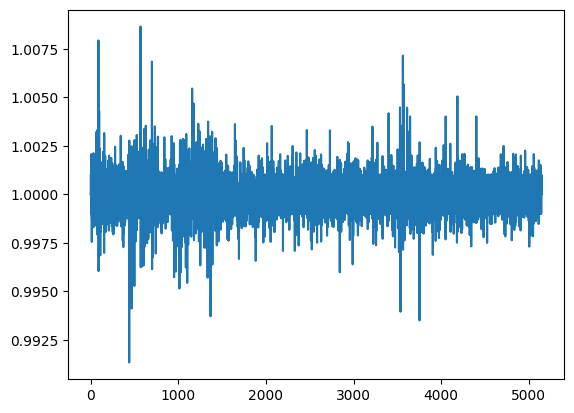

In [17]:
returns = Pt/Pt_1
plt.plot(returns)

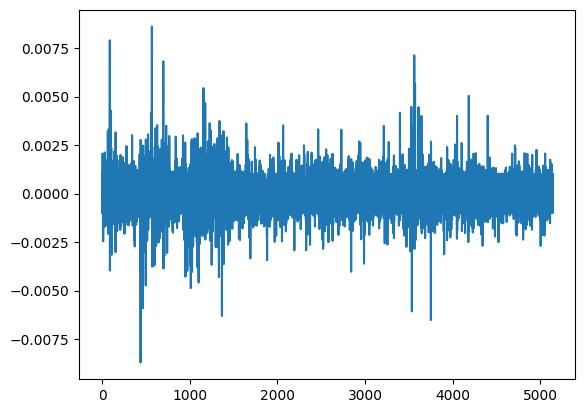

In [18]:
log_returns = np.log(returns)
plt.plot(log_returns)

In [19]:
realized_volatility = np.std(log_returns)
realized_volatility

np.float64(0.0010845364533086516)

With all the closing prices, we can visualize the volatility for the blocks. The volatility calculation below can be summed up as follows:

1. First, calculate the log returns of the prices:

$$R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

Where P are the prices at "block close (t)". So, R is calculated based on a price and another price in a previous timeframe.



Then to calculate the volatility:

$$Vol =100 \sqrt{ \frac{m}{n} \sum_{t=1}^{n} R_t^2}$$


It uses the log returns to calculate the volatility. It is normal to have another fraction multiplying the sum, to define a standardization of the timeframes. It is common to define in terms of years. For example, the number of trading days in a year (m) divided by the number of trading days in the timeframe (n). This won't work right with timeframe on-chain, because everyday is a trading day. 

Maybe these are other good candidates for more convenient for  DeFi timeframes?




In [20]:

# this is the interval at which we collect price data (defining its granulariy) in terms of blocks
# price_interval = 1 means we take the last price in a given block
price_interval = 1

# this is the window size for calculating returns (defining the gap between the current and previous price) in terms of blocks
# return_window = 25 means we calculate the return between the current price and the price 25 blocks ago (5 minutes ago)
return_window = 25
return_window_type = "percent" # "log" or "percent" (type of return calculation)

# this is the period size used to calculate realized volatility in terms of blocks (over what range are we computing volatility)
# volatility_period = 300 means we calculate the volatility over the last 300 blocks (1 hour)
volatility_period = 2400
volatility_period_type = "period" # "standardized" or "period" (type of volatility calculation)

# this is the period size used by any fee tier calculation in terms of blocks (over what range are we comparing volatility)
# fee_comparison = 300 means we calculate the fee using the last 300 blocks for comparison (1 hour)
fee_comparison = 2400
fee_method = "static" # "static" or "z_score" (type of fee calculation)

# this is the window size for calculating volume (defining the gap between the current and previous volume) in terms of blocks
volume_window = 25

taking every swap in the block
- using the tick values for the current and previous block

we are using this tick value: 

$$ 

\begin{align*}
\log_{\sqrt{1.0001}}\left(\frac{sqrtPriceX96}{Q96}\right) &= \text{tick}
\end{align*}
$$




$$R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$


- R = return
- t = block number 
- t-25 = 5 minute interval assuming 12 second block time
- P = price at block t
- P-25 = price at block t-25

$$R_t = \frac{P_t}{P_{t-25}}

- n = total number of blocks to use to calculate the volatility (these are the blocks trailing the current block)
- n = 2400 == 8 hours at a 12 second block time
- R_t = return at block t
- \bar{R} = average return over the period

$$vol = \sqrt{ \frac{1}{n-1} \sum_{t=1}^{n} (R_i - \bar{R})^2 }

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(-2000.0, 0, '−2000'),
  Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000')])

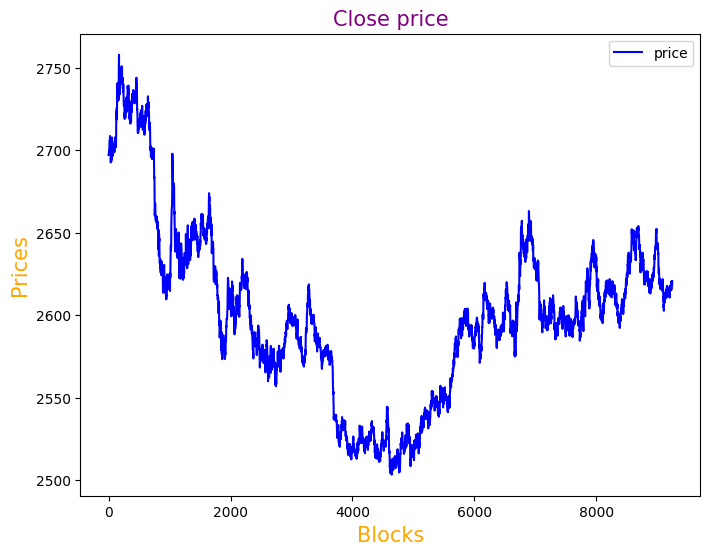

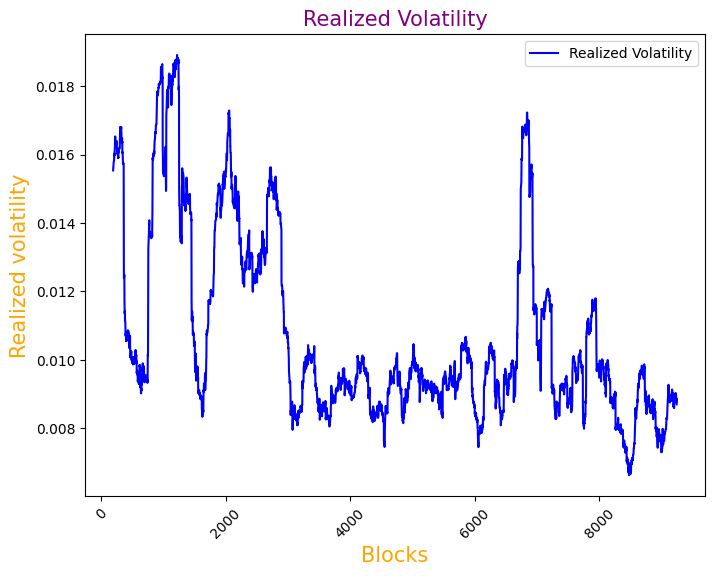

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# compute log returns
closing_prices = closing_prices.assign(Log_Ret=np.log(closing_prices['price'] / closing_prices['price'].shift(1)))
closing_prices.shape

 
# Compute Volatility using the pandas rolling standard deviation function
closing_prices['Realized Volatility'] = closing_prices['Log_Ret'].rolling(window=100).std() * np.sqrt(100)


# Plot the price series and the Volatility
closing_prices[['price']].plot(subplots=True, color='blue',figsize=(8, 6))
plt.title('Close price', color='purple', size=15)

plt.xlabel('Blocks', {'color': 'orange', 'fontsize':15})
plt.ylabel('Prices', {'color': 'orange', 'fontsize':15})

closing_prices[['Realized Volatility']].plot(subplots=True, color='blue',figsize=(8, 6))
plt.title('Realized Volatility', color='purple', size=15)


# Setting axes labels for realized volatility plot

plt.xlabel('Blocks', {'color': 'orange', 'fontsize':15})

plt.ylabel('Realized volatility', {'color': 'orange', 'fontsize':15})


# Rotating the values along x-axis to 45 degrees
plt.xticks(rotation=45)

 


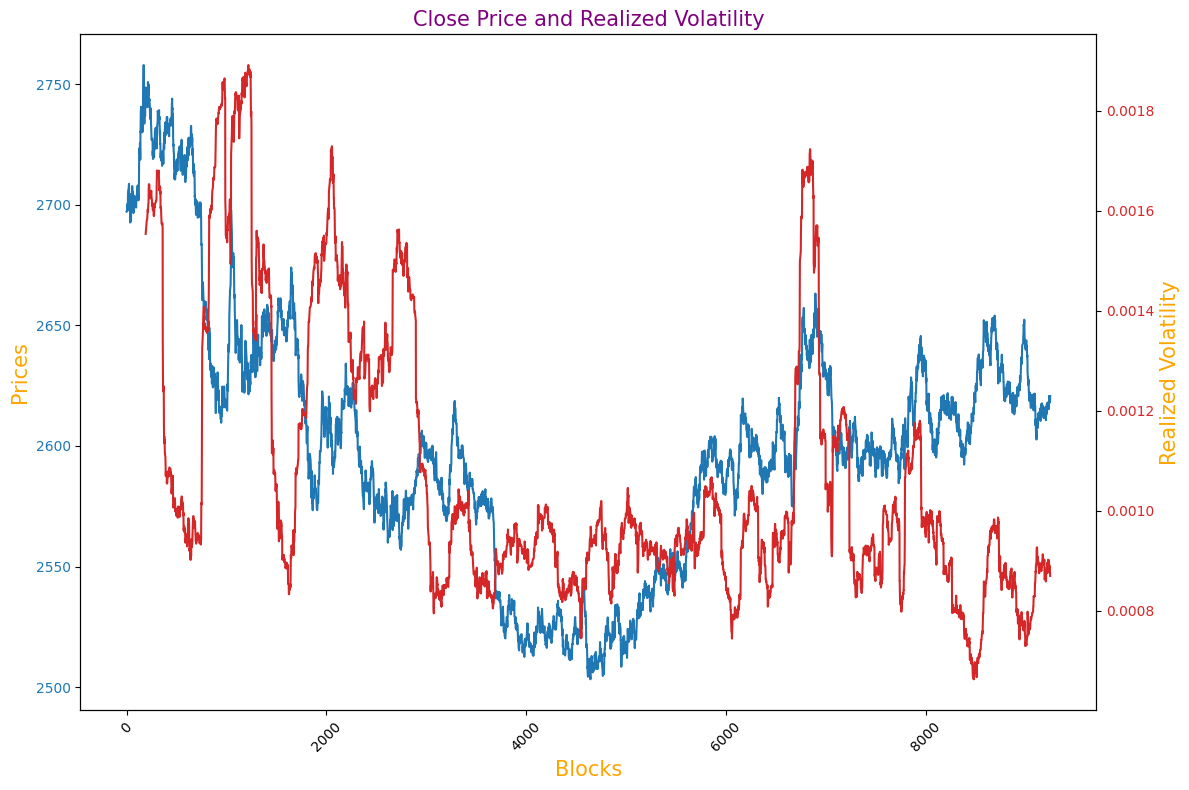

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# compute log returns
closing_prices = closing_prices.assign(Log_Ret=np.log(closing_prices['price'] / closing_prices['price'].shift(1)))
closing_prices.shape

 
# Compute Volatility using the pandas rolling standard deviation function
closing_prices['Realized Volatility'] = closing_prices['Log_Ret'].rolling(window=100).std()


# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting the price series
color = 'tab:blue'
ax1.set_xlabel('Blocks', color='orange', fontsize=15)
ax1.set_ylabel('Prices', color='orange', fontsize=15)
ax1.plot(closing_prices.index, closing_prices['price'], color=color)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Close Price and Realized Volatility', color='purple', size=15)

# Creating a second y-axis for the realized volatility
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Realized Volatility', color='orange', fontsize=15)
ax2.plot(closing_prices.index, closing_prices['Realized Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()

 


## Possible usages of this calculation inside smart contracts

If we get proofs of the realized volatility onchain, how can we use them in the uniswap v4 hooks?

These are some aspects I'm wondering about:

- [Volatility Arbitrage](https://quantra.quantinsti.com/glossary/Volatility-Arbitrage)
- rearranging LP liquidity provision based on the volatilty of many UniswapV3Pools.

# Volatility Analysis

We have pulled data from two weeks prior and two weeks post the FTX debacle. Our goal is two fold: 

- calculate the volatility over this range
- utilize this volatility to adjust the baseline fee for the pool

We will iteratively build on the complexity of our volatility calculation to achieve this goal. For any set of price data we will want to.

- [x] set the price data to a "full block" view, where we have a price for every block 
    - [x] we will have to decide at what granulatiry we want to take the price data (e.g. at the end of each block, every 10 blocks, etc.)
- [x] we will need to determine over which time frame we want to calculate the returns (e.g. change in price over 5 minutes, 1 block, etc.)
    - [x] we will need a way to vary how we calculate the returns (e.g. log returns, percent returns, etc.)
- [x] we will need a way to calculate the realized volatility over a certain time frame (e.g. 100 blocks, 5 minutes, etc.)
    - [x] we will need a way to vary how we calculate the realized volatility (e.g. rolling standard deviation, etc.)
- [x] we will need a way to map this volatility to a fee scalar (e.g. increase fee to 0.1% if volatility is above 0.5, etc.)
    - [x] we will need a way to vary how we map the volatility to the fee scalar (e.g. static rules, relative ratio, etc.)

#### Assumptions: 
- Ethereum mainnet block time is 12 seconds 

#### Recommendations:
- expand_price_data(interval=1): This sets the price data to be collected at the end of each block. We do not currently support intra-block price data collection. If needed, we can add this feature.
- calculate_returns(window=25, measure="log"): This sets the return window to calculate using the price 25 blocks ago (5 min) using the log of the percent change. Optionally, "percent" can be used to calculate the percent change.

In [23]:
test_data = {
    "evt_block_number": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
    "evt_index": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    "price": [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 110],
}

test_df = pd.DataFrame(test_data)

In [184]:
def drop_outliers(df, column, threshold=1.5, lower_bound=0.25, upper_bound=0.75):
    Q1 = df[column].quantile(lower_bound)
    Q3 = df[column].quantile(upper_bound)
    IQR = Q3 - Q1
    
    # Define outliers as values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [25]:
def set_price_interval(df, interval=1, block_col="evt_block_number", index_col="evt_index", interval_col="interval"): 
    """A function to group the price data by a set interval, determining the opening and closing price for each interval."""
    df = df.sort_values(by=[block_col, index_col])
    df[interval_col] = df[block_col] // interval
    df[interval_col] = df['interval'].astype(int)
    return df.groupby(interval_col).tail(1).reset_index(drop=True)

def expand_price_data(df, interval=1, block_col="evt_block_number", index_col="evt_index", price_col="price"): 
    """This function takes a DataFrame with price data and returns an expanded DataFrame mapping each block to a price. 
    TODO: determine how we want to handle the truncation of starting blocks due to the interval.
    """
    df = set_price_interval(df, interval=interval, block_col=block_col, index_col=index_col).drop(columns=['interval'])
    min_block = df[block_col].min()
    max_block = df[block_col].max() + 1
    all_blocks = pd.DataFrame({'evt_block_number': np.arange(min_block, max_block)})
    all_blocks = all_blocks.merge(df, how='left', on=block_col)
    all_blocks[price_col] = all_blocks[price_col].fillna(method='ffill')
    return all_blocks
# test_expanded_data = expand_price_data(test_df, interval=1)
# test_expanded_data

In [26]:
def update_log_returns(df, window=1, price_col="price", return_col="return"):
    return df.assign(**{return_col: np.log(df[price_col] / df[price_col].shift(window))})
def update_percent_change_returns(df, window=1, price_col="price", return_col="return"):
    return df.assign(**{return_col: df[price_col].pct_change(window)})

def calculate_returns(df, window=25, measure="log", price_col="price", return_col="return"):
    """A function to calculate returns from price data. Expects a fully expanded block-price DataFrame.
    """
    if measure == "log":
        return update_log_returns(df, window=window, price_col=price_col, return_col=return_col)
    elif measure == "percent":
        return update_percent_change_returns(df, window=window, price_col=price_col, return_col=return_col)
    else:
        raise ValueError(f"Invalid measure: {measure}")
# test_expanded_data = calculate_returns(test_expanded_data, window=2, measure="log")   
# test_expanded_data

In [27]:
def update_standardized_volatility(df, period=300, return_col="return", volatility_col="realized_volatility"):
    return df.assign(**{volatility_col: df[return_col].rolling(window=period).std() * np.sqrt(period)})
def updated_period_volatility(df, period=300, return_col="return", volatility_col="realized_volatility"):
    return df.assign(**{volatility_col: df[return_col].rolling(window=period).std()})

def calculate_realized_volatility(df, period=300, volatility_calc="standardized", return_col="return", volatility_col="realized_volatility"):
    """A function to calculate realized volatility from returns. Expects a fully expanded block-price-return DataFrame."""
    if volatility_calc == "standardized":
        return update_standardized_volatility(df, period=period, return_col=return_col, volatility_col=volatility_col)
    elif volatility_calc == "period":
        return updated_period_volatility(df, period=period, return_col=return_col, volatility_col=volatility_col)
    else:
        raise ValueError(f"Invalid volatility calculation: {volatility_calc}")
# test_expanded_data = calculate_realized_volatility(test_expanded_data, period=2, volatility_calc="period")
# test_expanded_data

In [28]:
class FeeTierRanges:
    def __init__(self):
        self.z_tiers = [
            (lambda x: x > 1, 0.01),
            (lambda x: -1 <= x <= 1, 0.005),
            (lambda x: -2 <= x < -1, 0.003),
            (lambda x: x < -2, 0.001),
        ]
        self.static_tiers = [
            (lambda x: x > 1, 0.01),
            (lambda x: .25 <= x <= 1, 0.005),
            (lambda x: .1 <= x < .25, 0.003),
            (lambda x: x < .1, 0.001),
        ]
    
    def get_z_fee(self, value):
        for condition, fee in self.z_tiers:
            if condition(value):
                return fee
        return None
    def get_static_fee(self, value):
        for condition, fee in self.static_tiers:
            if condition(value):
                return fee
        return None

In [29]:
def get_volatility_z_score(df, comparison=300, volatility_col="realized_volatility", z_score_col="z_score"):
    df['rolling_volatility_mean'] = df[volatility_col].rolling(window=comparison).mean()
    df['rolling_volatility_std'] = df[volatility_col].rolling(window=comparison).std()
    df[z_score_col] = (df[volatility_col] - df['rolling_volatility_mean']) / df['rolling_volatility_std']
    df = df.drop(columns=['rolling_volatility_mean', 'rolling_volatility_std'])
    return df

def get_volatility_z_score_fee_tier(df, comparison=300, volatility_col="realized_volatility", z_score_col="z_score", fee_col="fee"):
    df = get_volatility_z_score(df, comparison=comparison, volatility_col=volatility_col, z_score_col=z_score_col)
    fee_tiers = FeeTierRanges()
    df[fee_col] = df[z_score_col].apply(fee_tiers.get_z_fee)
    df = df.drop(columns=[z_score_col])
    return df

def get_static_fee_tier(df, volatility_col="realized_volatility", fee_col="fee"):
    fee_tiers = FeeTierRanges()
    df[fee_col] = df[volatility_col].apply(fee_tiers.get_static_fee)
    return df

def calculate_fee_scalar(df, method="static", base_fee_tier=0.0005, comparison=300, volatility_col="realized_volatility", fee_col="fee"):
    if method == "static":
        df = get_static_fee_tier(df, volatility_col=volatility_col, fee_col=fee_col)
    elif method == "z_score":
        df = get_volatility_z_score_fee_tier(df, comparison=comparison, volatility_col=volatility_col, fee_col=fee_col)
    else:
        raise ValueError(f"Invalid method: {method}")
    df[fee_col] = df[fee_col].fillna(base_fee_tier)
    return df  
# test_expanded_data = calculate_fee_scalar(test_expanded_data, method="z_score", comparison=2)
# test_expanded_data

In [30]:
def plot_single_line(df, x_col, y_col, title, x_label, y_label, color='blue'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df[x_col], df[y_col], color=color)
    ax.set_title(title, color='purple', size=15)
    ax.set_xlabel(x_label, color='orange', fontsize=15)
    ax.set_ylabel(y_label, color='orange', fontsize=15)
    plt.show()

def plot_dual_line(df, x_col, y1_col, y2_col, title, x_label, y1_label, y2_label, color1='blue', color2='red'):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(df[x_col], df[y1_col], color=color1)
    ax1.set_xlabel(x_label, color='orange', fontsize=15)
    ax1.set_ylabel(y1_label, color='orange', fontsize=15)
    ax1.set_title(title, color='purple', size=15)
    ax2 = ax1.twinx()
    ax2.plot(df[x_col], df[y2_col], color=color2)
    ax2.set_ylabel(y2_label, color='orange', fontsize=15)
    plt.show()

def plot_triple_line(df, x_col, y1_col, y2_col, y3_col, title, x_label, y1_label, y2_label, y3_label, color1='blue', color2='red', color3='green'):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.plot(df[x_col], df[y1_col], color=color1, label=y1_label)
    ax1.set_xlabel(x_label, color='orange', fontsize=15)
    ax1.set_ylabel(y1_label, color=color1, fontsize=15)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax2 = ax1.twinx()
    ax2.plot(df[x_col], df[y2_col], color=color2, label=y2_label)
    ax2.set_ylabel(y2_label, color=color2, fontsize=15)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(df[x_col], df[y3_col], color=color3, label=y3_label)
    ax3.set_ylabel(y3_label, color=color3, fontsize=15)
    ax3.tick_params(axis='y', labelcolor=color3)
    
    plt.title(title, color='purple', fontsize=15)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
    
    plt.show()

In [31]:
def get_block_volume(df, volume_col="volume", block_col="evt_block_number"):
    df = df.groupby(block_col).agg({volume_col: 'sum'}).reset_index()
    block_volume_map = dict(zip(df[block_col], df[volume_col]))
    return block_volume_map

def update_block_volume(df, volume_col="volume", block_col="evt_block_number"):
    block_volume_map = get_block_volume(df, volume_col=volume_col, block_col=block_col)
    df['block_volume'] = df[block_col].map(block_volume_map)
    return df

def get_window_volume(df, window=300, volume_col="block_volume", block_col="evt_block_number"):
    df['rolling_volume'] = df[volume_col].rolling(window=window).sum()
    return df

In [63]:
import math

Q96 = 2 ** 96

def tick_to_sqrt_price_x_96(tick):
    return int(1.0001 ** (tick / 2) * Q96)

def sqrt_price_x_96_to_tick(sqrt_price_x_96):
    base = math.sqrt(1.0001)
    p = sqrt_price_x_96 / Q96
    return math.floor(math.log(p, base))

def x_96_to_price(x_96):
    return math.sqrt(x_96 / Q96)

## Analysis

In [32]:
# this is where we define ranges for each fee calculation method
class FeeTierRanges:
    def __init__(self):
        self.z_tiers = [
            (lambda x: x > 1, 0.001),
            (lambda x: -1 <= x <= 1, 0.0005),
            (lambda x: -2 <= x < -1, 0.0003),
            (lambda x: x < -2, 0.0001),
        ]
        self.static_tiers = [
            (lambda x: x > 0.004, 0.001),
            (lambda x: 0.002 <= x <= 0.004, 0.0005),
            (lambda x: .001 <= x < .002, 0.0003),
            (lambda x: x < .001, 0.0001),
        ]
    
    def get_z_fee(self, value):
        for condition, fee in self.z_tiers:
            if condition(value):
                return fee
        return None
    def get_static_fee(self, value):
        for condition, fee in self.static_tiers:
            if condition(value):
                return fee
        return None

In [64]:
# variables 

# this is the interval at which we collect price data (defining its granulariy) in terms of blocks
# price_interval = 1 means we take the last price in a given block
price_interval = 1

# this is the window size for calculating returns (defining the gap between the current and previous price) in terms of blocks
# return_window = 25 means we calculate the return between the current price and the price 25 blocks ago (5 minutes ago)
return_window = 25
return_window_type = "percent" # "log" or "percent" (type of return calculation)

# this is the period size used to calculate realized volatility in terms of blocks (over what range are we computing volatility)
# volatility_period = 300 means we calculate the volatility over the last 300 blocks (1 hour)
volatility_period = 2400
volatility_period_type = "period" # "standardized" or "period" (type of volatility calculation)

# this is the period size used by any fee tier calculation in terms of blocks (over what range are we comparing volatility)
# fee_comparison = 300 means we calculate the fee using the last 300 blocks for comparison (1 hour)
fee_comparison = 2400
fee_method = "static" # "static" or "z_score" (type of fee calculation)

# this is the window size for calculating volume (defining the gap between the current and previous volume) in terms of blocks
volume_window = 25

In [65]:
folder_path = '../../output/files'
data = parse_jsonl_files_in_folder(folder_path)
# data = parse_json_file('../../output/files/0014250000-0014260000.jsonl')

df = pd.DataFrame(data)
df['USDC_float'] = abs(df['amount0'].astype(float) / 10**6)
df['ETH_float'] = abs(df['amount1'].astype(float) / 10**18)
df['price'] = df['USDC_float'] / df['ETH_float']
df = df.sort_values(by=['evt_block_number', 'evt_index'])

# print length before and after dropping outliers
print(f"Length before dropping outliers: {len(df)}")
# df = drop_outliers(df, 'price')
print(f"Length after dropping outliers: {len(df)}")
df.head(1)

Length before dropping outliers: 333233
Length after dropping outliers: 333233


,evt_tx_hash,evt_index,evt_block_time,evt_block_number,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,tick,USDC_float,ETH_float,price
0,fcc3ee07bf8d919ab9de764f18bc5ef418856a39f185c2...,2,2022-02-21T14:37:39Z,14250006,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",10478339758,-3884917900821301808,1525917532358317971760838574935194,24251487342182036943,197325,10478.339758,3.884918,2697.184349


In [39]:
# format the expanded data
expanded_data_df = expand_price_data(df, interval=price_interval)

# calculate the returns
expanded_data_df = calculate_returns(expanded_data_df, window=return_window, measure=return_window_type)

# calculate the realized volatility
expanded_data_df = calculate_realized_volatility(expanded_data_df, period=volatility_period, volatility_calc=volatility_period_type)

# apply a fee scalar to the data
expanded_data_df = calculate_fee_scalar(expanded_data_df, method=fee_method, comparison=fee_comparison)

# update the expanded data to include block volume
expanded_data_df = update_block_volume(expanded_data_df, volume_col='USDC_float')

# update the expanded data to include the rolling volume for a given window
expanded_data_df = get_window_volume(expanded_data_df, window=volume_window, volume_col='block_volume')

# calculate a basic standard deviation for the volume over the period 
expanded_data_df = calculate_realized_volatility(
    df=expanded_data_df,
    period=volatility_period,
    volatility_calc="period",
    return_col="block_volume",
    volatility_col="simple_volume_volatility"
)

# compute the change in rolling volume from one block to the next
expanded_data_df = calculate_returns(
    df=expanded_data_df,
    window=1,
    measure="percent",
    price_col="rolling_volume",
    return_col="rolling_volume_change"
)

# compute the volatility of the rolling volume change
expanded_data_df = calculate_realized_volatility(
    df=expanded_data_df,
    period=volatility_period,
    volatility_calc="period",
    return_col="rolling_volume_change",
    volatility_col="rolling_volume_change_volatility"
)

expanded_data_df.head(1)

/var/folders/02/c8m_xc4s1vgc4cz1l4zlp3t40000gn/T/ipykernel_42949/1085971224.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_blocks[price_col] = all_blocks[price_col].fillna(method='ffill')


,evt_block_number,evt_tx_hash,evt_index,evt_block_time,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,...,ETH_float,price,return,realized_volatility,fee,block_volume,rolling_volume,simple_volume_volatility,rolling_volume_change,rolling_volume_change_volatility
0,14250006,fcc3ee07bf8d919ab9de764f18bc5ef418856a39f185c2...,2.0,2022-02-21T14:37:39Z,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",10478339758,-3884917900821301808,1525917532358317971760838574935194,24251487342182036943,...,3.884918,2697.184349,NaN,NaN,0.0005,10478.339758,NaN,NaN,NaN,NaN


In [41]:
expanded_data_df["rolling_volume_change_volatility"].min(), expanded_data_df["rolling_volume_change_volatility"].max()

(np.float64(0.22790577568915574), np.float64(22.60838645643466))

In [42]:
expanded_data_df["realized_volatility"].min(), expanded_data_df["realized_volatility"].max()

(np.float64(0.0008571303618365169), np.float64(0.05767745948730414))

In [43]:
expanded_data_df["volume_weighted_price_volatility"] = expanded_data_df["realized_volatility"] * expanded_data_df["simple_volume_volatility"]
expanded_data_df["volume_weighted_price_volatility"].min(), expanded_data_df["volume_weighted_price_volatility"].max()

(np.float64(49.386574858974484), np.float64(10251.994453774934))

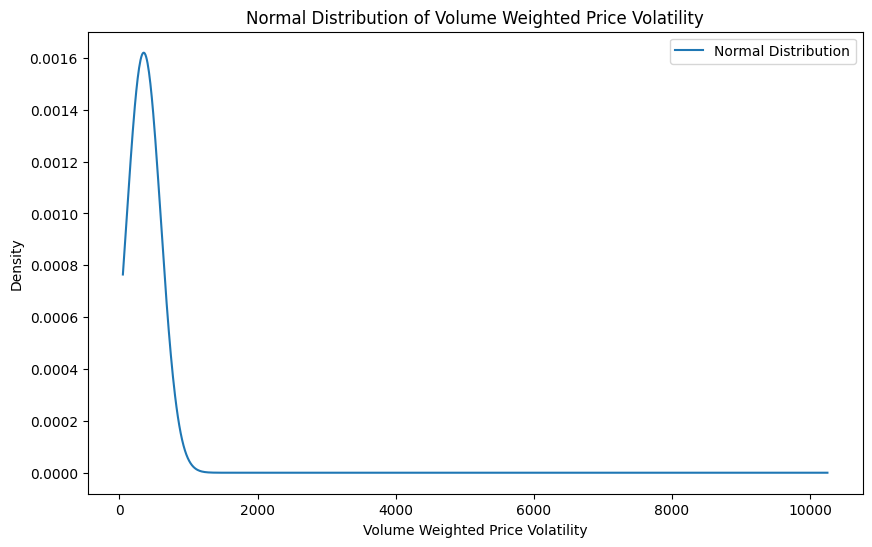

In [46]:
# plot the distribution of this newly computed metric
data = expanded_data_df["volume_weighted_price_volatility"]

mean = data.mean()
std_dev = data.std()

x = np.linspace(data.min(), data.max(), 1000)
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.xlabel('Volume Weighted Price Volatility')
plt.ylabel('Density')
plt.title('Normal Distribution of Volume Weighted Price Volatility')
plt.legend()
plt.show()

The +1 z-score: 597.5063750224842
The -1 z-score: 104.94742155648083
The +2 z-score: 843.7858517554859
The -2 z-score: -141.33205517652084


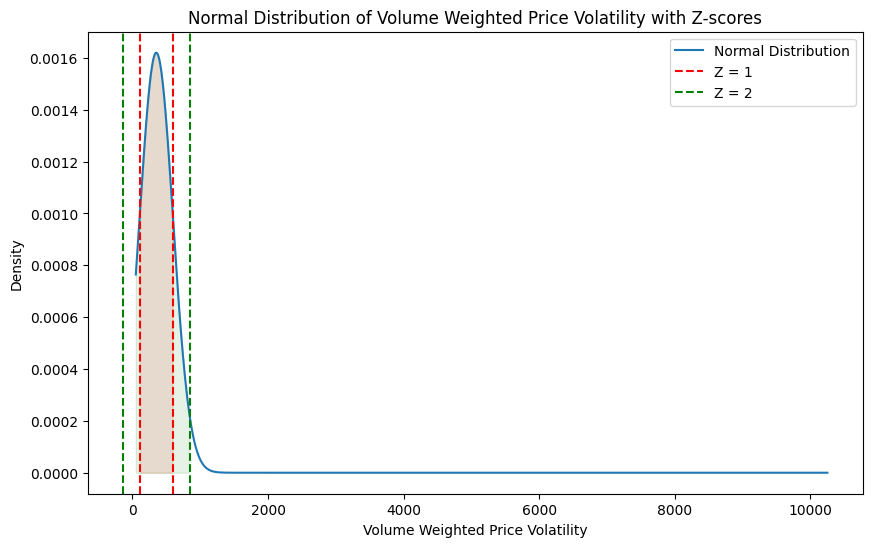

In [48]:
data = expanded_data_df["volume_weighted_price_volatility"]

mean = data.mean()
std_dev = data.std()

x = np.linspace(data.min(), data.max(), 1000)
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')

z1 = mean + std_dev
z_1 = mean - std_dev
z2 = mean + 2 * std_dev
z_2 = mean - 2 * std_dev

print(f"The +1 z-score: {z1}")
print(f"The -1 z-score: {z_1}")
print(f"The +2 z-score: {z2}")
print(f"The -2 z-score: {z_2}")

plt.axvline(z1, color='r', linestyle='--', label='Z = 1')
plt.axvline(z_1, color='r', linestyle='--')
plt.axvline(z2, color='g', linestyle='--', label='Z = 2')
plt.axvline(z_2, color='g', linestyle='--')

plt.fill_between(x, 0, y, where=(x >= z_1) & (x <= z1), color='red', alpha=0.1)
plt.fill_between(x, 0, y, where=(x >= z_2) & (x <= z2), color='green', alpha=0.1)

plt.xlabel('Volume Weighted Price Volatility')
plt.ylabel('Density')
plt.title('Normal Distribution of Volume Weighted Price Volatility with Z-scores')
plt.legend()
plt.show()


## Calculating Z-Score for the Entire Period

Since we have a measure of volatilty for the period, we can calculate the z-score of the volatility and use this to adjust the fee. 

In [56]:
from scipy.stats import norm

In [62]:
import math

def erf(x):
    # Constants for the approximation
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911

    # Save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # Abramowitz and Stegun formula 7.1.26
    t = 1.0 / (1.0 + p * x) # div - expensive
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * math.exp(-x * x) # exp - expensive

    return sign * y

def cdf(z):
    # Standard normal cumulative distribution function
    return 0.5 * (1 + erf(z / math.sqrt(2))) # sqrt - expensive 

# Example Z-score
z_score = -2

# Compute the CDF value for the Z-score
cdf_value = cdf(z_score)

print(f"Z-score: {z_score}")
print(f"CDF Value: {cdf_value:.5f}")
print(f"Sci-py CDF Value: {norm.cdf(z_score):.5f}") 


Z-score: -2
CDF Value: 0.02275
Sci-py CDF Value: 0.02275


In [53]:
realized_volatility_mean = expanded_data_df["realized_volatility"].mean()
realized_volatility_std = expanded_data_df["realized_volatility"].std()

expanded_data_df["realized_volatility_z_score"] = (expanded_data_df["realized_volatility"] - realized_volatility_mean) / realized_volatility_std
expanded_data_df

,evt_block_number,evt_tx_hash,evt_index,evt_block_time,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,...,return,realized_volatility,fee,block_volume,rolling_volume,simple_volume_volatility,rolling_volume_change,rolling_volume_change_volatility,volume_weighted_price_volatility,realized_volatility_z_score
0,14250006,fcc3ee07bf8d919ab9de764f18bc5ef418856a39f185c2...,2.0,2022-02-21T14:37:39Z,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",10478339758,-3884917900821301808,1525917532358317971760838574935194,24251487342182036943,...,NaN,NaN,0.0005,10478.339758,NaN,NaN,NaN,NaN,NaN,NaN
1,14250007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0005,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,14250008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0005,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,14250009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0005,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,14250010,bc79ade25faa4a0265525b01f78d7a2fc3f7b3a57b50ea...,437.0,2022-02-21T14:37:54Z,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[211, 78, 72, 85, 20, 106, 192, 198, 208, 228,...",4340404907,-1609216608786697661,1525912275143648921512703657856255,24251487342182036943,...,NaN,NaN,0.0005,4340.404907,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369989,14619995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000190,0.001510,0.0003,0.000000,4.260821e+05,95478.410406,0.000000,0.803012,144.126696,-0.578314
369990,14619996,7db80cc5239ea9c8e31145d45f9e3cc5add691763c149c...,260.0,2022-04-20T05:26:16Z,"[76, 177, 131, 134, 229, 209, 243, 77, 198, 23...","[86, 23, 138, 13, 95, 48, 27, 175, 108, 243, 2...",289181021765,-93710693329375875871,1426462147119921017953010891140489,30044952485740603838,...,0.000090,0.001508,0.0003,289181.021765,6.889124e+05,95627.388721,0.616854,0.803092,144.182225,-0.579866
369991,14619997,98583a7b8e7ec16953d70ef34e388ca10388c5b680af2f...,70.0,2022-04-20T05:26:32Z,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",54890378220,-17783861996260918702,1426415251299099210511043045210504,30044952485740603838,...,0.001290,0.001507,0.0003,54890.378220,7.437127e+05,95628.234055,0.079546,0.803091,144.117996,-0.580466
369992,14619998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000288,0.001507,0.0003,0.000000,7.428215e+05,95628.758788,-0.001198,0.803091,144.085917,-0.580767


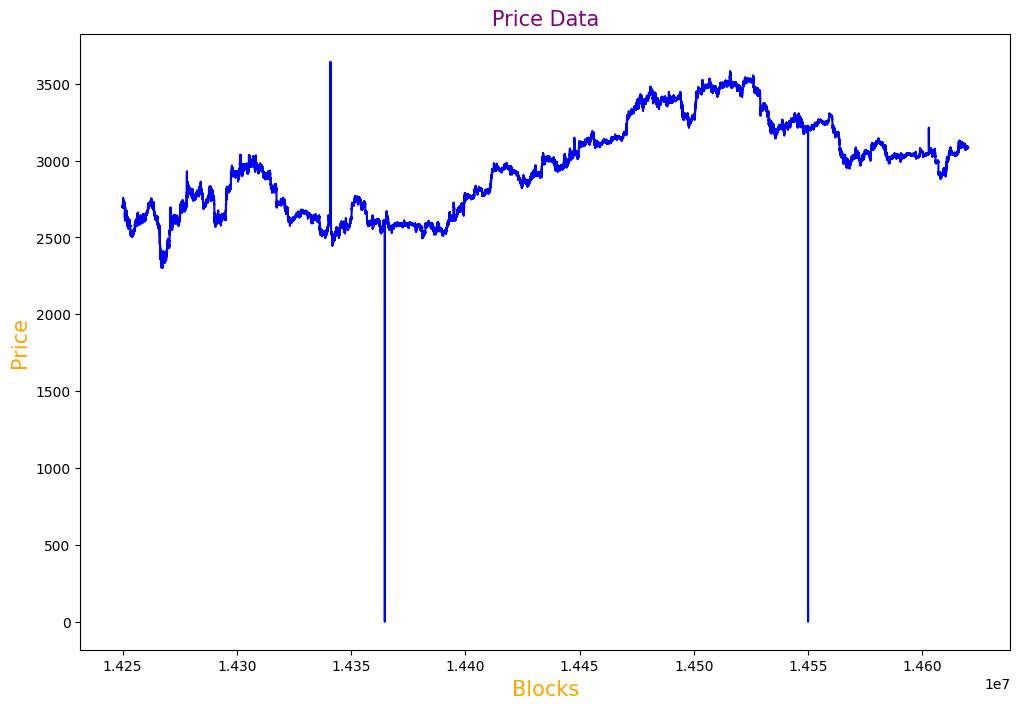

In [444]:
plot_single_line(
    df=expanded_data_df,
    x_col='evt_block_number',
    y_col='price',
    title='Price Data',
    x_label='Blocks',
    y_label='Price',
    color='blue'
)

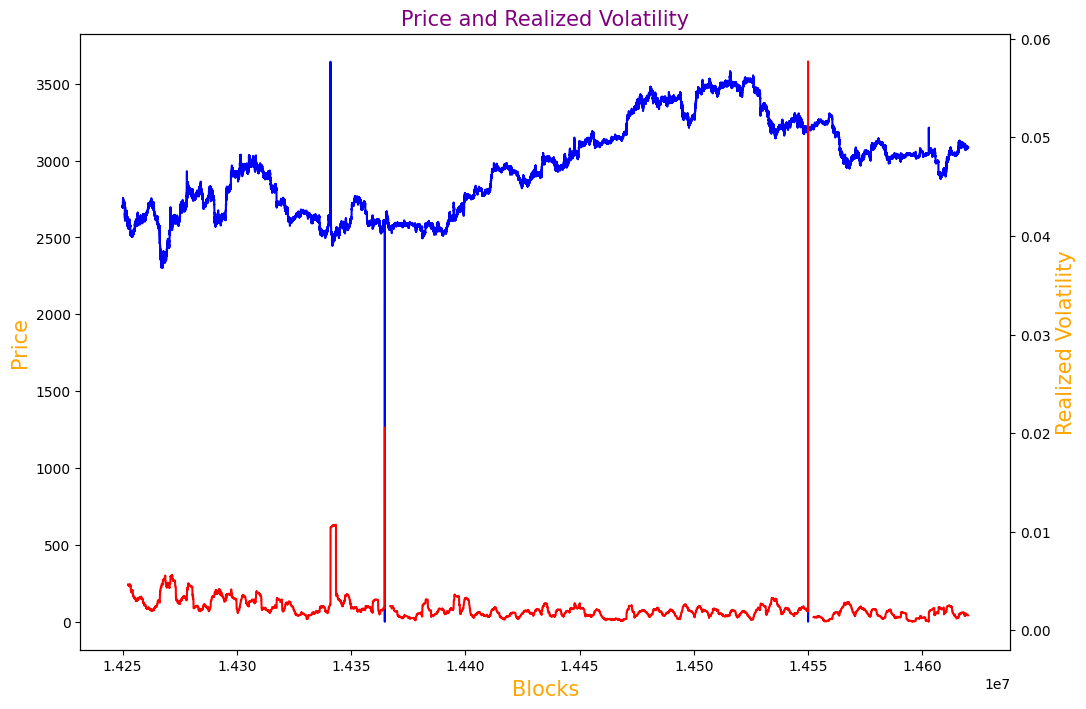

In [445]:
plot_dual_line(
    df=expanded_data_df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='realized_volatility',
    title='Price and Realized Volatility',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Realized Volatility',
    color1='blue',
    color2='red'
)

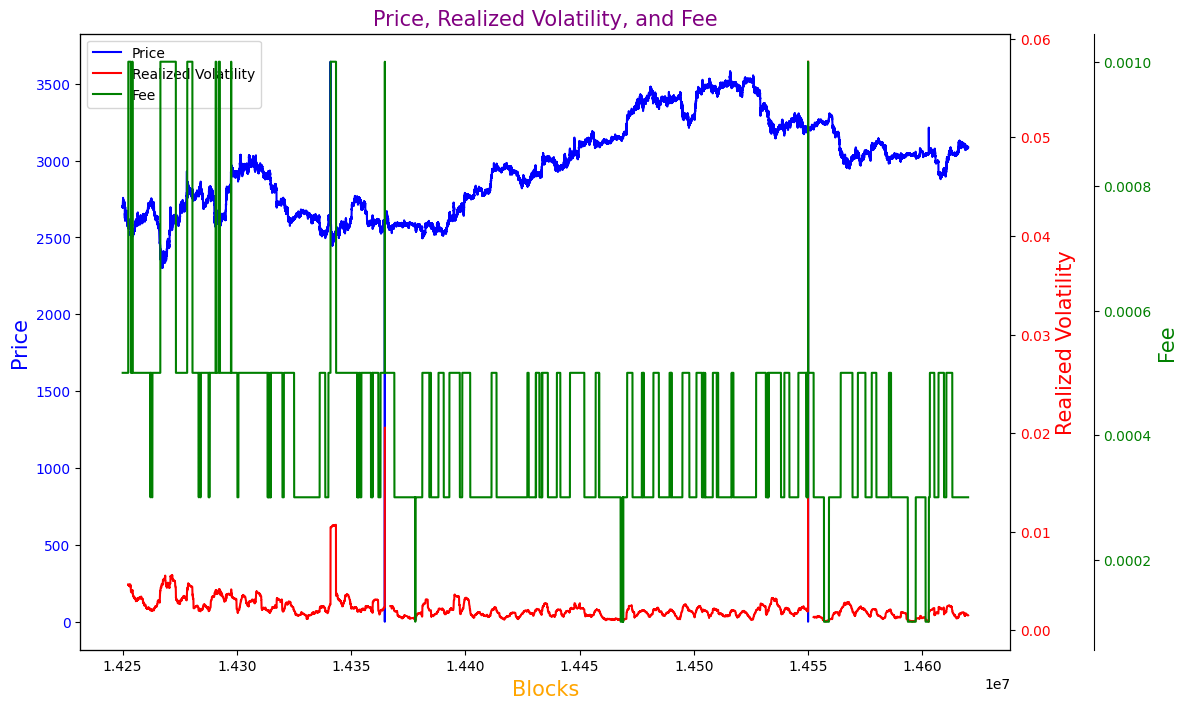

In [446]:
plot_triple_line(
    df=expanded_data_df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='realized_volatility',
    y3_col='fee',
    title='Price, Realized Volatility, and Fee',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Realized Volatility',
    y3_label='Fee',
    color1='blue',
    color2='red',
    color3='green'
)

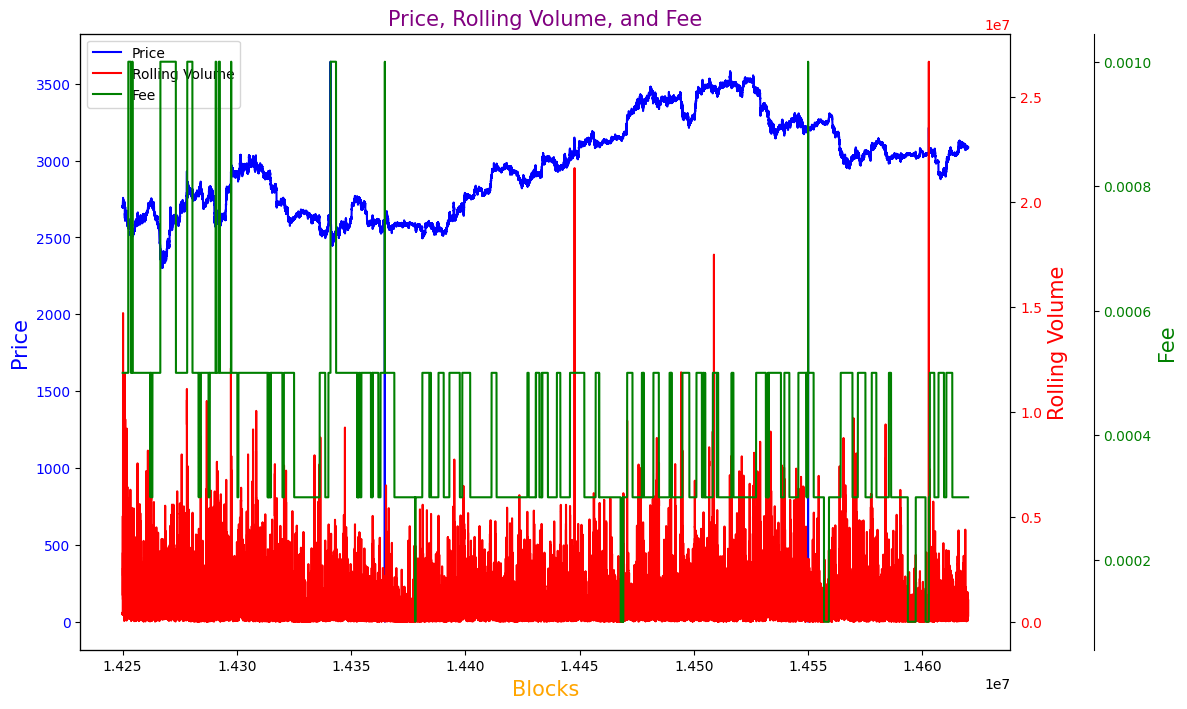

In [469]:
plot_triple_line(
    df=expanded_data_df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='rolling_volume',
    y3_col='fee',
    title='Price, Rolling Volume, and Fee',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Rolling Volume',
    y3_label='Fee',
    color1='blue',
    color2='red',
    color3='green'
)

- This can be expanded to utilyze the volume in association with the volatility to adjust the fee scalar.

## Updated Work: Tick Based Volatility

TLDR: Using `volatility_to_fee` provide a volatility measure using the percentile change of tick values on a tick-by-tick basis.

```python
import math
from typing import Optional

def erf(x):
    # Constants for the approximation
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911

    # Save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # Abramowitz and Stegun formula 7.1.26
    t = 1.0 / (1.0 + p * x) # div - expensive
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * math.exp(-x * x) # exp - expensive

    return sign * y

def cdf(z):
    # Standard normal cumulative distribution function
    return 0.5 * (1 + erf(z / math.sqrt(2))) # sqrt - expensive 

def calculate_z_score(
        realized_volatility: int,
        population_mean: Optional[float] = 0.0000281642917638877927455180738558482289590756408870220184326171875,
        population_std: Optional[float] = 0.00001073326355537635901798466930845421529738814570009708404541015625,
): 
    """Expects the realized volatility as computed utilizing the log returns of tick values from the ETH/USDC pair on a tick-to-tick basis."""
    return (realized_volatility - population_mean) / population_std

def calculate_fee_scalar(
        z_score: float,
        distribution_shift: Optional[float] = 0.5,
):
    """Returns a fee scalar given a Z-score and a distribution shift. Distribution is the percentile rank. Shift is the shift to adjust what the mean value percentile is."""
    return cdf(z_score) + distribution_shift

def volatility_to_fee(
        volatility: float,
        base_fee: Optional[float] = 0.0005,
): 
    """Take a volatility value and convert it to a fee."""
    z_score = calculate_z_score(volatility)
    fee_scalar = calculate_fee_scalar(z_score)
    return base_fee * fee_scalar
```

In [259]:
def drop_outliers(df, column, threshold=1.5, lower_bound=0.25, upper_bound=0.75):
    Q1 = df[column].quantile(lower_bound)
    Q3 = df[column].quantile(upper_bound)
    IQR = Q3 - Q1
    
    # Define outliers as values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [260]:
# load the relevant data
folder_path = '../../output/files'
data = parse_jsonl_files_in_folder(folder_path)
# data = parse_json_file('../../output/files/0014250000-0014260000.jsonl')

df = pd.DataFrame(data)
df['USDC_float'] = abs(df['amount0'].astype(float) / 10**6)
df['ETH_float'] = abs(df['amount1'].astype(float) / 10**18)
df['price'] = df['USDC_float'] / df['ETH_float']
df = df.sort_values(by=['evt_block_number', 'evt_index'])

In [261]:
# drop any outliers based on unreasonable price values
print(f"Length before dropping outliers: {len(df)}")
df = drop_outliers(df, 'price', threshold=2)
print(f"Length after dropping outliers: {len(df)}")
df.head(1)

Length before dropping outliers: 333233
Length after dropping outliers: 333227


,evt_tx_hash,evt_index,evt_block_time,evt_block_number,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,tick,USDC_float,ETH_float,price
0,fcc3ee07bf8d919ab9de764f18bc5ef418856a39f185c2...,2,2022-02-21T14:37:39Z,14250006,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",10478339758,-3884917900821301808,1525917532358317971760838574935194,24251487342182036943,197325,10478.339758,3.884918,2697.184349


In [262]:
# calculate the returns on a tick-by-tick basis (using the tick data)
df['return'] = df['tick'].pct_change(1)

In [ ]:
# compute the realized volatility for a trailing period
df = df.sort_values(by=['evt_block_number', 'evt_index']).reset_index(drop=True)

window_size = 8192
realized_volatility = np.zeros(len(df))

block_numbers = df['evt_block_number'].values
indexes = df['evt_index'].values
returns = df['return'].values

for i in range(len(df)):
    current_block = block_numbers[i]
    current_index = indexes[i]

    start_block = current_block - window_size

    mask = (block_numbers >= start_block) & (block_numbers <= current_block) & \
           ((block_numbers < current_block) | ((block_numbers == current_block) & (indexes <= current_index)))
    
    window_returns = returns[mask]
    realized_volatility[i] = np.std(window_returns, ddof=1)
df['realized_volatility'] = realized_volatility

In [264]:
# get the mean and standard deviation of the realized volatility
population_mean = df['realized_volatility'].mean()
population_std = df['realized_volatility'].std()

print(f"Population mean: {str(population_mean)}")
print(f"Population standard deviation: {population_std}")

# calculate the Z-score for the realized volatility
df['z_score'] = (df['realized_volatility'] - population_mean) / population_std

Population mean: 2.8164291763887793e-05
Population standard deviation: 1.0733263555376359e-05


In [269]:
print("Population mean: {:.80f}".format(population_mean))
print("Population standard deviation: {:.80f}".format(population_std))

Population mean: 0.00002816429176388779274551807385584822895907564088702201843261718750000000000000
Population standard deviation: 0.00001073326355537635901798466930845421529738814570009708404541015625000000000000


In [ ]:
import math
from typing import Optional

def erf(x):
    # Constants for the approximation
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911

    # Save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # Abramowitz and Stegun formula 7.1.26
    t = 1.0 / (1.0 + p * x) # div - expensive
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * math.exp(-x * x) # exp - expensive

    return sign * y

def cdf(z):
    # Standard normal cumulative distribution function
    return 0.5 * (1 + erf(z / math.sqrt(2))) # sqrt - expensive 

def calculate_z_score(
        realized_volatility: int,
        population_mean: Optional[float] = 0.0000281642917638877927455180738558482289590756408870220184326171875,
        population_std: Optional[float] = 0.00001073326355537635901798466930845421529738814570009708404541015625,
): 
    """Expects the realized volatility as computed utilizing the log returns of tick values from the ETH/USDC pair on a tick-to-tick basis."""
    return (realized_volatility - population_mean) / population_std

def calculate_fee_scalar(
        z_score: float,
        distribution_shift: Optional[float] = 0.5,
):
    """Returns a fee scalar given a Z-score and a distribution shift. Distribution is the percentile rank. Shift is the shift to adjust what the mean value percentile is."""
    return cdf(z_score) + distribution_shift

def volatility_to_fee(
        volatility: float,
        base_fee: Optional[float] = 0.0005,
): 
    """Take a volatility value and convert it to a fee."""
    z_score = calculate_z_score(volatility)
    fee_scalar = calculate_fee_scalar(z_score)
    return base_fee * fee_scalar

In [245]:
# solve for the percentile of the Z-score
df["percentile"] = df["z_score"].apply(lambda x: norm.cdf(x))

# adjust the fee scalar so that we are increasing the fee when > 50th percentile
df["fee_scalar"] = df["percentile"] + .5

# apply the fee scalar to the fee (using a 0.05% base fee)
df["fee"] = df["fee_scalar"] * .0005 # 0.05% fee

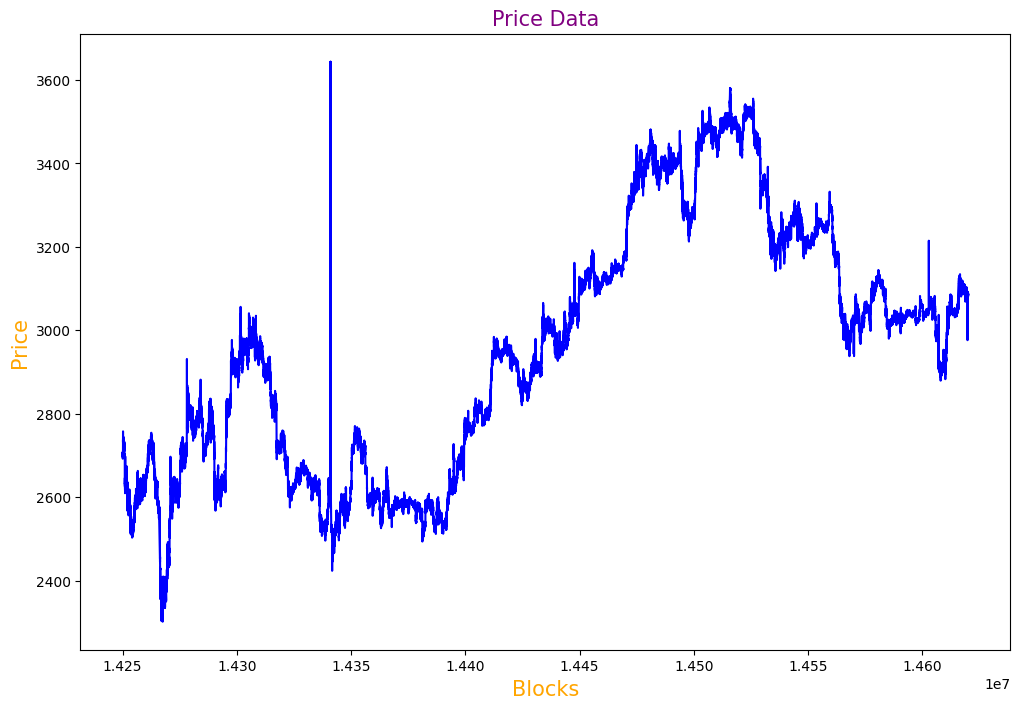

In [246]:
plot_single_line(
    df=df,
    x_col='evt_block_number',
    y_col='price',
    title='Price Data',
    x_label='Blocks',
    y_label='Price',
    color='blue'
)

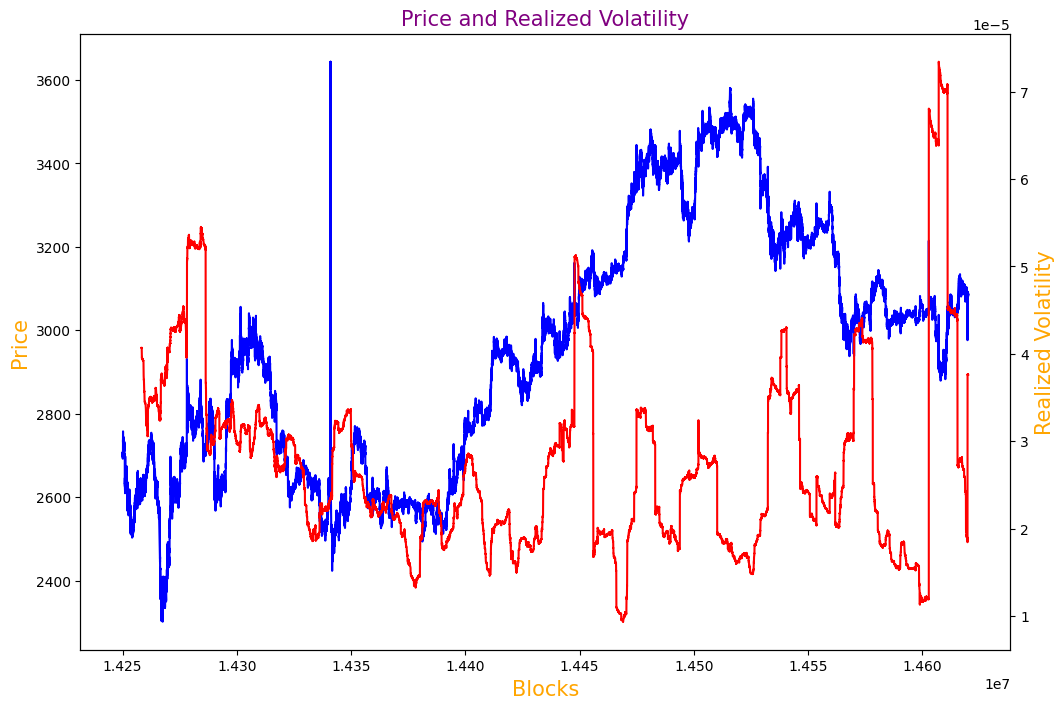

In [247]:
plot_dual_line(
    df=df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='realized_volatility',
    title='Price and Realized Volatility',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Realized Volatility',
    color1='blue',
    color2='red'
)

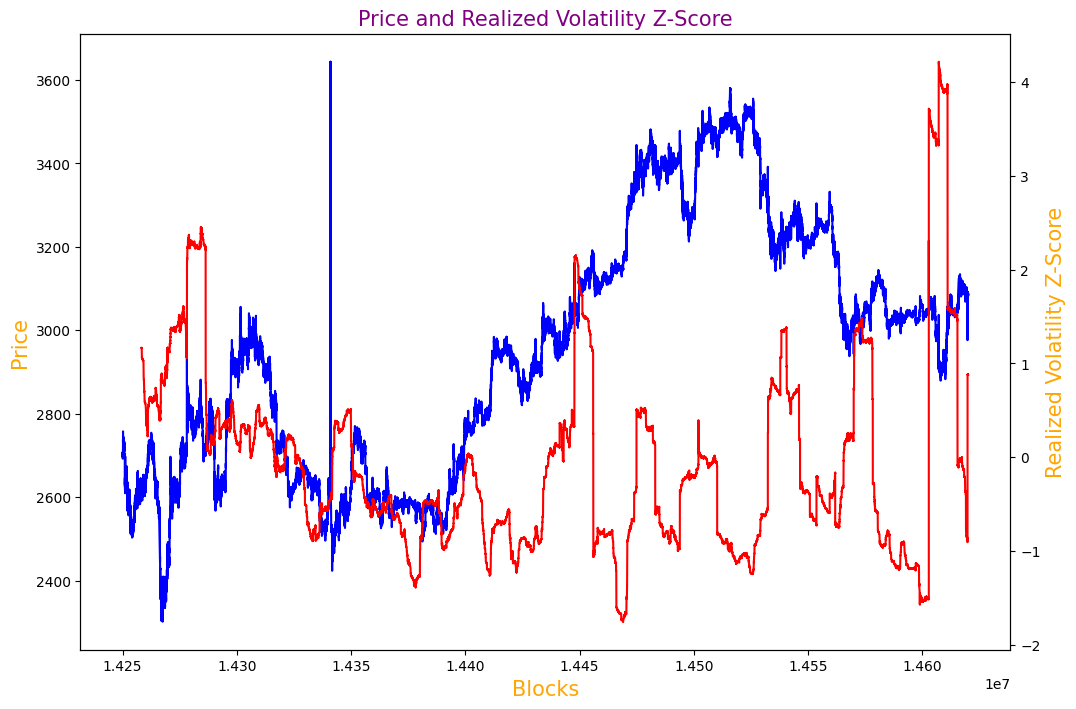

In [248]:
plot_dual_line(
    df=df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='z_score',
    title='Price and Realized Volatility Z-Score',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Realized Volatility Z-Score',
    color1='blue',
    color2='red'
)

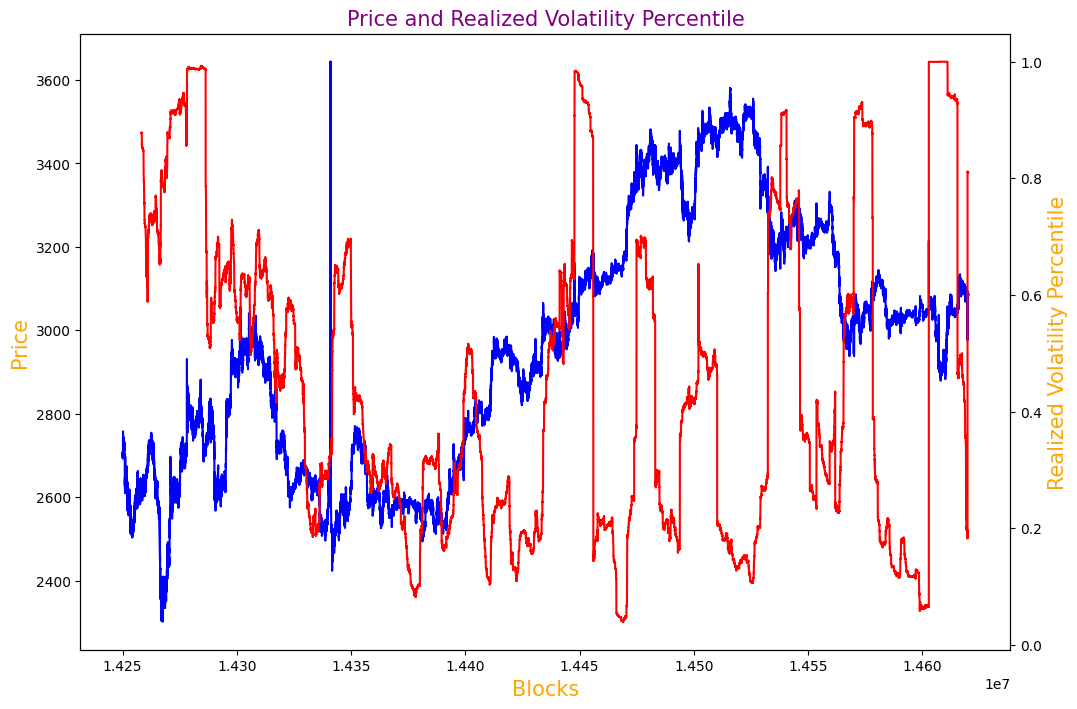

In [249]:
plot_dual_line(
    df=df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='percentile',
    title='Price and Realized Volatility Percentile',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Realized Volatility Percentile',
    color1='blue',
    color2='red'
)

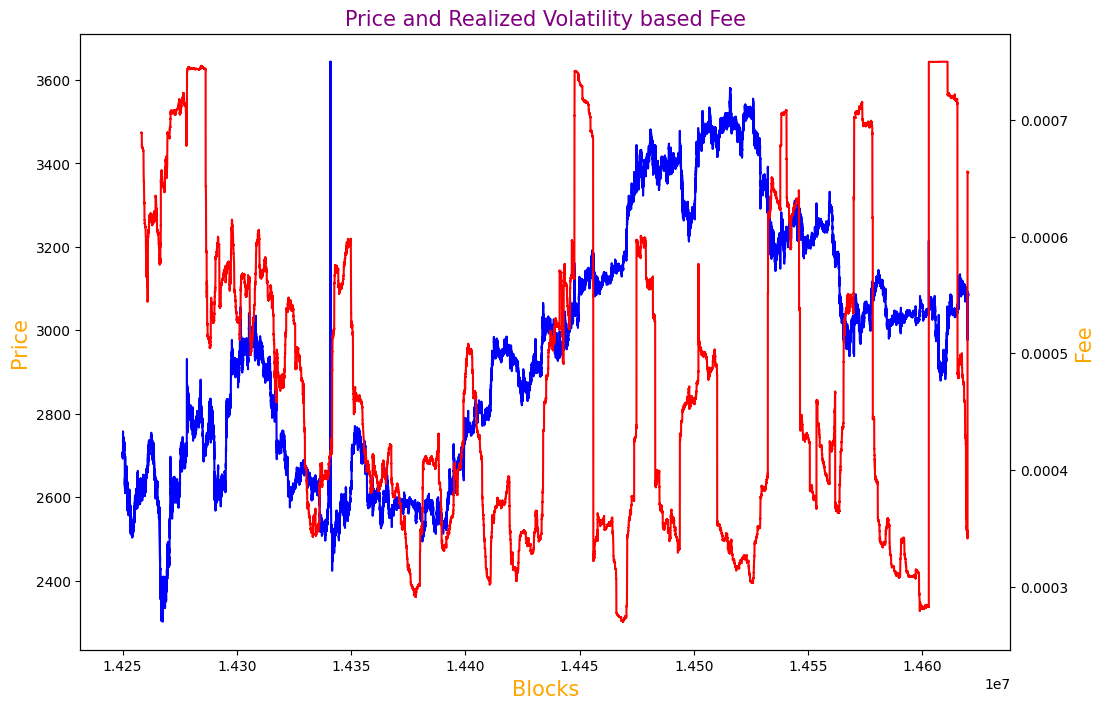

In [254]:
plot_dual_line(
    df=df,
    x_col='evt_block_number',
    y1_col='price',
    y2_col='fee',
    title='Price and Realized Volatility based Fee',
    x_label='Blocks',
    y1_label='Price',
    y2_label='Fee',
    color1='blue',
    color2='red'
)

## Error Function Approximation

The error function, `erf(x)`, can be approximated using the Abramowitz and Stegun formula 7.1.26. The formula and constants used for the approximation are as follows:

### Constants
\[
\begin{align*}
a_1 &= 0.254829592 \\
a_2 &= -0.284496736 \\
a_3 &= 1.421413741 \\
a_4 &= -1.453152027 \\
a_5 &= 1.061405429 \\
p &= 0.3275911 \\
\end{align*}
\]

### Error Function Formula
The approximation formula for the error function is given by:

$$
\text{erf}(x) \approx \text{sign}(x) \left[ 1 - \left( a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5 \right) e^{-x^2} \right]
$$

where \( t \) is defined as:

$$
t = \frac{1}{1 + p |x|}
$$

### Steps
1. **Save the sign of \( x \)**:
   $$
   \text{sign}(x) = \begin{cases} 
   1 & \text{if } x \geq 0 \\
   -1 & \text{if } x < 0 
   \end{cases}
   $$

2. **Compute \( t \)**:
   $$
   t = \frac{1}{1 + p |x|}
   $$

3. **Compute the approximation**:
   $$
   \text{erf}(x) \approx \text{sign}(x) \left[ 1 - \left( a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5 \right) e^{-x^2} \right]
   $$

Here is the Python implementation of this approximation:

```python
import math

def erf(x):
    # Constants for the approximation
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911

    # Save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # Abramowitz and Stegun formula 7.1.26
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * math.exp(-x * x)

    return sign * y


## Cumulative Distribution Function (CDF)

The cumulative distribution function (CDF) of the standard normal distribution can be approximated using the error function (`erf`). The formula used in the `cdf` function is as follows:

### Error Function
The error function, `erf(x)`, is defined as:

$$
\text{erf}(x) \approx \text{sign}(x) \left[ 1 - \left( a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5 \right) e^{-x^2} \right]
$$

where \( t \) is defined as:

$$
t = \frac{1}{1 + p |x|}
$$

### CDF Formula
The CDF of the standard normal distribution is given by:

$$
\Phi(z) = 0.5 \left( 1 + \text{erf}\left( \frac{z}{\sqrt{2}} \right) \right)
$$

Here is the Python implementation of the `cdf` function:

```python
import math

def cdf(z):
    # Standard normal cumulative distribution function
    return 0.5 * (1 + erf(z / math.sqrt(2))) # sqrt - expensive
```


## Z-Score Calculation

The Z-score is a measure of how many standard deviations a data point is from the mean of the dataset. The formula used in the `z_score` function is as follows:

### Z-Score Formula
The Z-score is calculated using the formula:

$$
Z = \frac{x - \mu}{\sigma}
$$

where:
- \( x \) is the data point,
- \( \mu \) is the mean of the dataset,
- \( \sigma \) is the standard deviation of the dataset.

Here is the Python implementation of the `z_score` function:

```python
def z_score(x, mean, std_dev):
    return (x - mean) / std_dev

For our analyzed data, we find the following: 
- Population mean: 2.8164291763887793e-05
- Population standard deviation: 1.0733263555376359e-05


## Realized Volaity Calculation

We calculate the realized volatility of the price change on a tick-by-tick basis. The formula used in the `realized_volatility` function is as follows:

$$
vol = \sqrt{ \frac{1}{n-1} \sum_{t=1}^{n} (R_i - \bar{R})^2 }
$$

where:
- (R_i - \bar{R}) is the difference between the return at time \( i \) and the average return over the period,
- \( n \) is the total number of blocks to use to calculate the volatility (these are the blocks trailing the current block), we use 8192 blocks (24 hours).

# Return Calculation

The return is calculated as the log return of the price change on a tick-by-tick basis (trade-to-trade). Since the `tick` is already in log space, we do not need to take the log of the price change. The formula used in the `return_calculation` function is as follows:

$$R_t = \frac{P_t}{P_{t-1}}$$

where:
- \( R_t \) is the return at block-index \( t \),
- \( P_t \) is the price at block-index \( t \),
- \( P_{t-1} \) is the price at block-index \( t-1 \).

## Fee Scalar

- fee = CDF(Z) + 0.5 (to set a fee scalar based on the z-score)
$$
x = \Phi(z) + 0.5
$$


In [253]:
df["evt_block_number"].min(), df["evt_block_number"].max()  

(np.int64(14250006), np.int64(14619999))